# 1 Introduction

The applications of recommender systems in businesses have become increasingly popular. Recommender systems apply various sources of information including demographics, social, and preferences to provide users with tailored recommended items. Moreover, the favoured technique for building recommender systems is Collaborative filtering. This technique is further divided into three main categories including Memory-Based, Model-Based, and Hybrid-BAsed. Therefore, as large businesses realise the advantages of recommending personalized items to users, the research for techniques, sources of information, and implementation grows. Netflix is among the big organisations interested in the expansion of recommmender system. The application of recommender systems at Netflix is widely known, however improvements are continiously being investigated to provide users with the best movie and series recommendations. Thus, this notebook aims to investigate the application of collaborative filtering techniques for Netflix.      

As a leading streaming service, Netflix is always looking for ways to enhance the user experience and provide more value to its subscribers. One area of interest for Netflix is the use of recommendations during pause screens. Specifically, Netflix is exploring the possibility of recommending jokes to users when they pause a movie or TV show. To achieve this, Netflix is researching the development of a recommender system that can not only recommend movies to users but also jokes that are relevant to the content they are currently watching. Such a system would require a deep understanding of user preferences, as well as the ability to analyze and categorize humor in a way that can be used to generate relevant and entertaining recommendations. With the right approach and a focus on accuracy and relevance, Netflix could potentially create a new and engaging way to keep users entertained and engaged even during the brief moments of pause in their viewing experience. Therefore, the following research questions were formulated:

#### Which type of RecSys based on CF could Netflix use to provide the most accurate recommendations of movies and jokes to users?

- How do the Netflix and Jester dataset compare?
- How does KNN calculate the recommended items?
- How does SVD calculate the recommended items?
- How do KNN and SVD perform on both datasets?

# 2 Importing Libraries

Importing the necessary libraries

In [524]:
# General imports
import os
import pandas as pd
import numpy as np

# Used for visualisations in the EDA
import seaborn as sns

# Used in reducing the memory storage of sparse matrices
from scipy.sparse import csr_matrix

# Used for creating a KNN and SVD RecSys model
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from scipy.sparse.linalg import svds

# Used for performance evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error

# As working with NaN values in matrices overwelmed the output with warnings 
# these warnings will be ignored.
import warnings
warnings.filterwarnings('ignore')

# 3 Data Processing

In [525]:
debugging = False

## 3.1 Netflix Dataset

### 3.1.1 Import Source Data

Code to append movieId to each record in all of the source files if this has not been executed earlier. This will allow all the source files to be loaded into a dataframe with one line of code and without having to add the movieId seperately before concatting the sourcefiles. This additionally resulted in a faster importing time of the source data.

In [526]:
def format_netflix_source():
    # Variable to keep track of which movieId has to be appended
    x = 0
    string = ","+str(x)

    # Loop through each file in the directory
    for filename in os.listdir(directory):
        with open(os.path.join(directory, filename), 'r') as f:
            # Check if the first line of the first file already has been formatted
            # If true formatting the source will be skipped
            if(f.readlines()[0] == '1:,1\n'):
                print('Source is already formatted, continuing \n')
                return
            else:
                print('Started formatting source files \n')
                # Append a ',', movieId and \n (newline) to each line resulting in an extra column with movieId when using pandas read_csv 
                file_lines = [''.join([x.strip(), string, '\n']) for x in f.readlines()]
        with open(os.path.join(directory, filename), 'w') as f:
            # Save the formatted file
            f.writelines(file_lines)
            print('Completed formatting source files')
    return

Creating the movie dataframe by concatting all the sourcefiles without their title (skiprows=1). Concluding with naming the columns.

In [527]:
# Define the folder in which all the seperate movie files are located
directory = "/Users/vbraun/Downloads/training_set/"

# Run the function to format the source data if necessary
format_netflix_source()

print('Started concatting all source files to DataFrame \n')
# Performing 1 concat on all sourcefiles to create one dataframe (including itemId)
# As the files do not have a header and differ between each other 'header' = None and the first row will be skipped
netflix_df = pd.concat(pd.read_csv(os.path.join(directory, fname), skiprows=1,header=None) for fname in os.listdir(directory)).rename(columns={0:'userId',1:'rating',2:'date',3:'itemId'})
print('Completed concatting all source files to DataFrame \n')

# Dropping the date column as this is not relevant for this recommender system
netflix_df = netflix_df.drop(columns='date')

display(netflix_df.head(3))

Source is already formatted, continuing 

Started concatting all source files to DataFrame 

Completed concatting all source files to DataFrame 



,userId,rating,itemId
0,1488844,3,1
1,822109,5,1
2,885013,4,1


### 3.1.2 Data Filtering

To allow for faster development a debugging variable is used. If debugging is True the dataset will only consist of the first 100 movies. For the final model, debugging will be set to False.

In [ ]:
# In order to achieve faster execution time of the while developing a selection of the total dataset is made when debugging = True
if debugging == True:
    print('Debugging is set to True: limiting the dataset to the first 100 movies')
    filtered_netflix_df = netflix_df[netflix_df['itemId'] <= 100]
else:
    filtered_netflix_df = netflix_df
print('Length of selected dataset: {0} \n'.format(len(filtered_netflix_df)))

In order to filter the dataset based on activity and reduce the sparsity of the data, the data will be grouped and filtered based on movies and users. The datasets will show how many ratings each movie has gotten and how many rating each user has given.

To reduce the sparcity of data in the dataset, we will filter out the users that have rated fewer than 5% of the total amount of movies.

Finally, the movies that have been rated by fewer than 50 people will be filtered out of the dataset.

In [561]:
# Making two dataframes: One grouping items to show how many ratings an item has gotten and one grouping users to show how many ratings an user has given
filtered_movie_count = filtered_netflix_df[['itemId','userId']].groupby('itemId').count().reset_index().rename(columns={'userId':'user_count'})
filtered_user_count = filtered_netflix_df[['itemId','userId']].groupby('userId').count().reset_index().rename(columns={'itemId':'item_count'})

# Defining the minimal percentage of items that a user has to have rated to be included
required_rated_percentage = 0.025
print('Filtering out users that have rated less than {0} percent of all movies'.format((required_rated_percentage*100)))

# Check if the userId exists when the total amount of items rated by a user (filtered_user_count['item_count']), divided by the total amount of movies (len(filtered_movie_count)' is bigger than the required_rated_percentage
filtered_netflix_df = filtered_netflix_df[filtered_netflix_df['userId'].isin(filtered_user_count[filtered_user_count['item_count']/len(filtered_movie_count) > required_rated_percentage]['userId'])]
print('Length of filtered dataset: {0} \n'.format(len(filtered_netflix_df)))

print('Filtering out movies that have been rated by fewer than {0} users'.format(50))
filtered_netflix_df = filtered_netflix_df[filtered_netflix_df['itemId'].isin(filtered_movie_count[filtered_movie_count['user_count']>50]['itemId'])]
print('Length of filtered dataset: ',len(filtered_netflix_df))

Filtering out users that have rated less than 2.5 percent of all movies
Length of filtered dataset: 155459 

Filtering out movies that have been rated by fewer than 50 users
Length of filtered dataset:  155459


## 3.2 Jester Dataset

### 3.2.1 Import Source Data

In [530]:
# Creating dataframes for the jester datasets
jester_items = pd.read_csv(r'C:\Users\vbraun\Downloads\SDM-Datasets\jester_items.csv')
jester_ratings = pd.read_csv(r'C:\Users\vbraun\Downloads\SDM-Datasets\jester_ratings.csv')

# Rename jokeId to itemId to have one uniform format for the Netflix and Jester dataset
jester_df = jester_ratings.rename(columns={'jokeId':'itemId'})

# The ratings given in the jester dataset range from -10 to 10. Since calculations including average ratings of users could be influenced by this, the ratings will be increase with 10 to range from 0 - 20. 
jester_df['rating'] = jester_df['rating'] + 10

### 3.2.2 Data filtering

In [564]:
# In order to achieve faster execution time of the while developing a selection of the total dataset is made when debugging = True
if debugging == True:
    print('Debugging is set to True: limiting the dataset to the first 50 jokes')
    filtered_jester_df = jester_df[jester_df['itemId'] <= 50]
else:
    filtered_jester_df = jester_df
print('Length of selected dataset: {0} \n'.format(len(filtered_jester_df)))

Debugging is set to True: limiting the dataset to the first 50 jokes
Length of selected dataset: 715403 



In [565]:
# Making two dataframes: One grouping items to show how many ratings an item has gotten and one grouping users to show how many ratings an user has given
jester_item_count = filtered_jester_df[['itemId','userId']].groupby('itemId').count().reset_index().rename(columns={'userId':'user_count'})
jester_user_count = filtered_jester_df[['itemId','userId']].groupby('userId').count().reset_index().rename(columns={'itemId':'item_count'})

# Defining the minimal percentage of items that a user has to have rated to be included
required_rated_percentage = 0.025
print('Filtering out users that have rated less than {0} percent of all jokes'.format(required_rated_percentage*100))

# Check if the userId exists when the total amount of items rated by a user (jester_user_count['item_count']), divided by the total amount of movies (len(jester_item_count)' is bigger than the required_rated_percentage
filtered_jester_df = filtered_jester_df[filtered_jester_df['userId'].isin(jester_user_count[jester_user_count['item_count']/len(jester_item_count) > required_rated_percentage]['userId'])]
print('Length of filtered dataset: {0} \n'.format(len(filtered_jester_df)))

print('Filtering out jokes that have been rated by fewer than {0} users'.format(20))
filtered_jester_df = filtered_jester_df[filtered_jester_df['itemId'].isin(jester_item_count[jester_item_count['user_count']>20]['itemId'])]
print('Length of filtered dataset:',len(filtered_jester_df))

Filtering out users that have rated less than 2.5 percent of all jokes
Length of filtered dataset: 714003 

Filtering out jokes that have been rated by fewer than 20 users
Length of filtered dataset: 714003


# 4 Exploratory Data Analysis (EDA)

This chapter will try to answer the following sub question: 'How do the netflix and jester dataset compare?'

## 4.1 EDA Netflix Dataset

In [533]:
print('The filtered netflix dataset has', filtered_netflix_df['userId'].nunique(), 'unique users')
print('The filtered netflix dataset has', filtered_netflix_df['itemId'].nunique(), 'unique movies')
print('The filtered netflix dataset has', filtered_netflix_df['rating'].nunique(), 'unique ratings')
print('The unique ratings are', sorted(filtered_netflix_df['rating'].unique()))

The filtered netflix dataset has 64434 unique users
The filtered netflix dataset has 17711 unique movies
The filtered netflix dataset has 5 unique ratings
The unique ratings are [1, 2, 3, 4, 5]


In [534]:
print('Amount of NaN values in the netflix dataset:',filtered_netflix_df.loc[lambda x: x.isnull().any(axis=1)].shape[0])

Amount of NaN values in the netflix dataset: 0


No NaN values were found in the dataset.

In [535]:
display(filtered_netflix_df.head(),filtered_netflix_df.tail())

,userId,rating,itemId
0,1488844,3,1
3,30878,4,1
4,823519,3,1
5,893988,3,1
7,1248029,3,1


,userId,rating,itemId
916,1790158,4,17770
917,1608708,3,17770
918,234275,1,17770
919,255278,4,17770
920,453585,2,17770


In [536]:
filtered_netflix_df.describe()

,userId,rating,itemId
count,5.181689e+07,5.181689e+07,5.181689e+07
mean,1.322522e+06,3.530406e+00,9.016454e+03
std,7.639584e+05,1.072275e+00,5.122567e+03
min,6.000000e+00,1.000000e+00,1.000000e+00
25%,6.642090e+05,3.000000e+00,4.656000e+03
50%,1.317179e+06,4.000000e+00,8.975000e+03
75%,1.984949e+06,4.000000e+00,1.355100e+04
max,2.649308e+06,5.000000e+00,1.777000e+04


The mean rating for all movies in the netflix dataset is quite high with a score of 3.53 on a scale of 1-5. Moreover, the standard deviation of 1.07 further exemplifies that users in the netflix dataset generally like the movies they watch as it suggests most given ratings ranging between 2.46 and 4.60. 
<br>
<br>
The following graph illustrates for each movie (represented as a dot) what the mean rating is that is has received in contrast to the total amount of ratings that were given. 

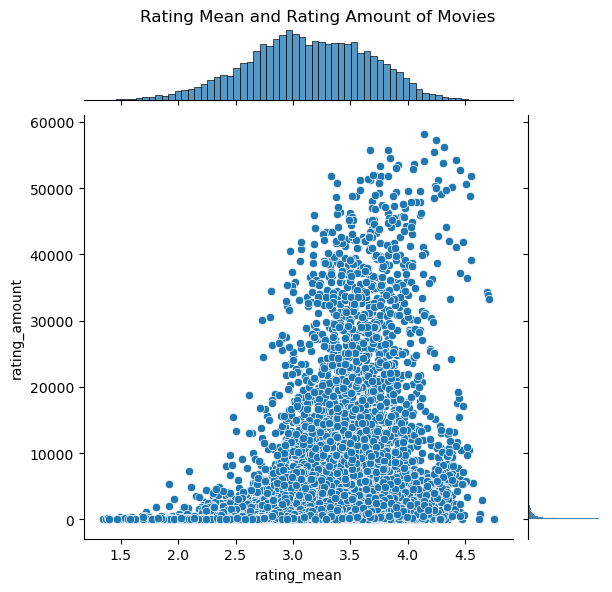

In [537]:
plt = sns.jointplot(x='rating_mean', y='rating_amount', data=filtered_netflix_df.groupby('itemId').agg(rating_mean = ('rating', 'mean'), rating_amount = ('rating', 'count')).reset_index())
plt.fig.suptitle("Rating Mean and Rating Amount of Movies")
plt.fig.subplots_adjust(top=0.95)

Notably, the mean rating of all movies approach a normal distribution. Whereas, there are many movies that have a low amount of ratings.
<br>
<br>
The following graph illustrates the mean rating a user has given compared to the amount of ratings that user has given.  

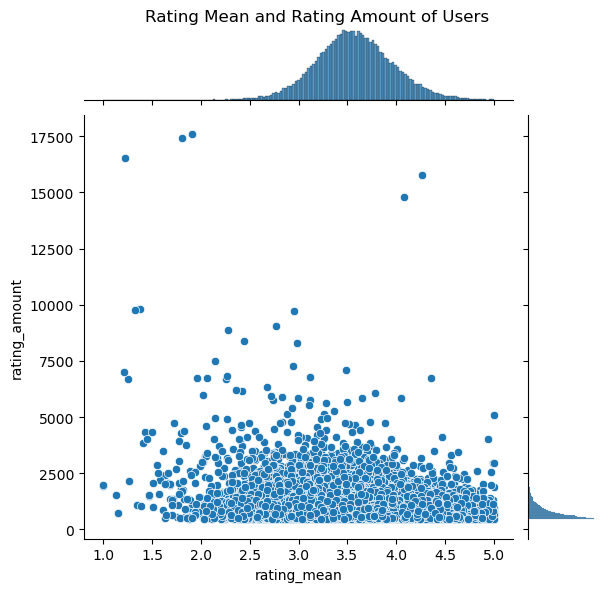

In [538]:
plt = sns.jointplot(x='rating_mean', y='rating_amount', data=filtered_netflix_df.groupby('userId').agg(rating_mean = ('rating', 'mean'), rating_amount = ('rating', 'count')).reset_index())
plt.fig.suptitle("Rating Mean and Rating Amount of Users")
plt.fig.subplots_adjust(top=0.95)

The graph for users show that there are several outliers of users that have rated many movies while having a low mean of their ratings. However, the barchart of the mean rating of users still looks like it approaches a normal distribution. 

## 4.2 EDA Jester Dataset

In [539]:
print('The filtered jester dataset has', filtered_jester_df['userId'].nunique(), 'unique users')
print('The filtered jester dataset has', filtered_jester_df['itemId'].nunique(), 'unique jokes')
print('The filtered jester dataset has', filtered_jester_df['rating'].nunique(), 'unique ratings')
print('The unique ratings are', sorted(filtered_jester_df['rating'].unique()))

The filtered jester dataset has 54947 unique users
The filtered jester dataset has 140 unique jokes
The filtered jester dataset has 641 unique ratings
The unique ratings are [0.0, 0.031000000000000583, 0.06199999999999939, 0.09399999999999942, 0.125, 0.15600000000000058, 0.1880000000000006, 0.21899999999999942, 0.25, 0.2810000000000006, 0.3119999999999994, 0.3439999999999994, 0.375, 0.4060000000000006, 0.4380000000000006, 0.4689999999999994, 0.5, 0.5310000000000006, 0.5619999999999994, 0.5939999999999994, 0.625, 0.6560000000000006, 0.6880000000000006, 0.7189999999999994, 0.75, 0.7810000000000006, 0.8119999999999994, 0.8439999999999994, 0.875, 0.9060000000000006, 0.9380000000000006, 0.9689999999999994, 1.0, 1.0310000000000006, 1.0620000000000012, 1.0939999999999994, 1.125, 1.1560000000000006, 1.1879999999999988, 1.2189999999999994, 1.25, 1.2810000000000006, 1.3120000000000012, 1.3439999999999994, 1.375, 1.4060000000000006, 1.4379999999999988, 1.4689999999999994, 1.5, 1.5310000000000006,

As is shown above, the ratings in the Jester contain 641 unique values that are in the form of floats instead of integer like the netflix dataset.

In [540]:
display(filtered_jester_df.head(),filtered_jester_df.tail())

,userId,itemId,rating
0,1,5,10.219
1,1,7,0.719
2,1,8,0.719
3,1,13,3.219
4,1,15,10.875


,userId,itemId,rating
1761434,63978,57,1.469
1761435,63978,24,0.938
1761436,63978,124,0.969
1761437,63978,58,1.344
1761438,63978,44,1.562


In [541]:
print('Amount of NaN values in the jester dataset:',filtered_jester_df.loc[lambda x: x.isnull().any(axis=1)].shape[0])

Amount of NaN values in the jester dataset: 0


No NaN values were found in the Jester dataset.

In [542]:
filtered_jester_df.describe()

,userId,itemId,rating
count,1.753066e+06,1.753066e+06,1.753066e+06
mean,3.273057e+04,7.100934e+01,1.162818e+01
std,1.826894e+04,4.591440e+01,5.293453e+00
min,1.000000e+00,5.000000e+00,0.000000e+00
25%,1.724400e+04,2.100000e+01,8.000000e+00
50%,3.482600e+04,6.900000e+01,1.225000e+01
75%,4.728700e+04,1.130000e+02,1.571900e+01
max,6.397800e+04,1.500000e+02,2.000000e+01


The mean rating for all jokes in the jester dataset is low in comparison with the netflix dataset as 11.17 on a scale of 0 - 20 is near the middle. It can therefore be important to provide better recommendations in order to show users jokes they like more.  

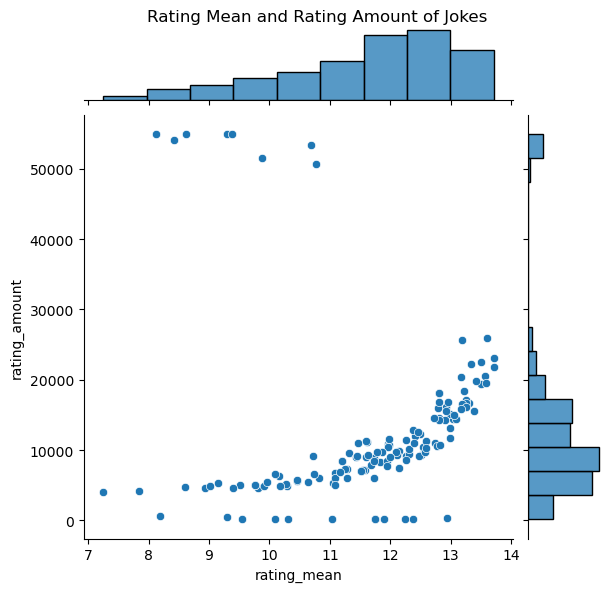

In [543]:
plt = sns.jointplot(x='rating_mean', y='rating_amount', data=filtered_jester_df.groupby('itemId').agg(rating_mean = ('rating', 'mean'), rating_amount = ('rating', 'count')).reset_index())
plt.fig.suptitle("Rating Mean and Rating Amount of Jokes")
plt.fig.subplots_adjust(top=0.95)

As illustrated above, the mean rating for each joke is not distributed evenly as there are a few jokes that got many ratings with a relatively low rating.  

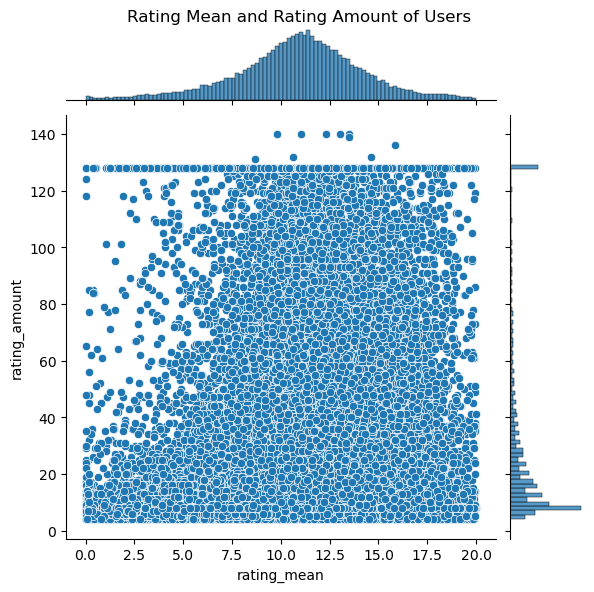

In [544]:
plt = sns.jointplot(x='rating_mean', y='rating_amount', data=filtered_jester_df.groupby('userId').agg(rating_mean = ('rating', 'mean'), rating_amount = ('rating', 'count')).reset_index())
plt.fig.suptitle("Rating Mean and Rating Amount of Users")
plt.fig.subplots_adjust(top=0.95)

The graph above shows that the ratings per user in the Jester are more evenly distributed along the axis compared to the users in the netflix dataset.    

In summary, the netflix and jester dataset are similar in format except for their rating scales and can be treated equally in the creation of RecSys. However, the users in the netflix dataset prove to give higher relative ratings compared to the users in the Jester dataset. Further research is required to understand the nature of these differences.  

# 5 Recommender Systems

This chapter will answer sub question 2 and 3 by building and explaining the KNN and SVD RecSys models based on CF. Both models will be evaluated using the same function that follows below. This function calculates the root mean squared error and the mean absolute error between actual values of y and the predicted value for that same y (without the RecSys model knowing what that y was).

In [551]:
def evaluate_predictions(pred, truth):
    # In order to only compare y's that were not 0, a selection is made from y and corresponding the y^ where y != 0 by using .nonzero() 
    pred = pred[truth.nonzero()].flatten()
    truth = truth[truth.nonzero()].flatten()

    # Standard RMSE and MAE calculations
    rmse = np.sqrt(mean_squared_error(truth,pred))
    mae = mean_absolute_error(truth,pred)
    return rmse, mae

In order to evaluate the performance of the recommendations following SVD we only need the $\hat{y}$ of existing $y$. Therefore, all other values will be filtered out of the prediction dataset by using pred[truth.nonzero()]. Afterwards we are able to evaluate the performance of our model by comparing $\hat{y}$ with their corresponding $y$. 

## 5.1 K Nearest Neighbors (KNN)

### 5.1.1 KNN Model

In order to train and test the KNN RecSys model the dataset will have to be split into train, validation and test data. This was created in a function to allow testing the performance of the model over many iterations. 

In [552]:
def train_test(filtered_df):
    # Since the data is sparse the pivot_table is performed in the csr_matrix to reduce the required memory 
    sparse_matrix = csr_matrix(filtered_df.pivot_table(index='userId', columns='itemId', values='rating').fillna(0).values)
    # print(sparse_matrix.check_format)

    # To train and evaluate the KNN model the sparse matrix is split into 70% train, 15% validation and 15% test data
    train_data, test_data = train_test_split(sparse_matrix, test_size=.30)
    test_data, validation_data = train_test_split(test_data, test_size=.50)

    return train_data, validation_data, test_data

K-Nearest Neighbors, is a commonly used algorithm in recommender systems for finding items that are similar to a given item or user. For KNN the similarity with other users is measured to find the closest neighbors. KNN works by identifying the k items that are most similar to a user's preferences or a given item based on some similarity metric. In our hyper parameter tuning several different metrics will be performed. Once these k items are identified, the system can then recommend these items to the user.

In [553]:
def calculate_weighted_knn_prediction(train_data, test_data, k = 5, metric = 'cosine'):
    # Create the NearestNeighbors model with the parameters passed in the function
    # Since the datasets are sparse the algorithm is set to 'brute'(force)
    knn_model = NearestNeighbors(metric=metric,algorithm='brute',n_jobs=-1)

    # Fit the model with the training data
    knn_model_fitted = knn_model.fit(train_data.toarray())

    # Find the closest distance with k amount of users for the passed 'test_data' (either the validation or test dataset depending on the stage)
    distance, indices = knn_model_fitted.kneighbors(test_data.toarray(),k)

    # Create a sorted list including the distances and userId for each user in the test_data that we can iterate through
    sorted_distance_list = sorted(list(zip(indices.squeeze().tolist(), distance.squeeze().tolist())), key=lambda x: x[1])
    
    # Transform the train_data to be able to search by index
    users_df = pd.DataFrame(train_data.toarray())

    # We will now iterate through the list calculating the average ratings given for each item by the k most similar users 
    knn_prediction = []
    for i, (idx, dist) in enumerate(sorted_distance_list):
        # Take the inverse of the distance to be used as weight 
        inv = 1 / np.array(dist)
        # Since some distances are close to 0 we need to set 'inf' values to an actual value in order to calculate the prediction
        inv[inv == np.inf] = 10000000
        
        # Select the rating of the similar users from the train dataset
        sim_users = np.array(users_df[users_df.index.isin(idx)])

        # Mask the 0 ratings of the similar user ratings
        masked_ar = np.ma.masked_values(sim_users, 0)
        # Calculate the average rating for each non masked item. The weight of each user is first multiplied with their given rating and then divided by the sum of the weights used on the non masked ratings.
        masked_ar_av = np.ma.average(masked_ar,axis=0,weights=inv)
        # masked_ar_av.data will provide the array without the mask returning 0 for all the masked items
        knn_prediction.append(masked_ar_av.data)

    return np.array(knn_prediction)


### 5.1.2 KNN Hyperparameter Tuning

In order to find the optimal parameters to create the KNN model with, hyperparameter tuning will be performed. In our case we will search for the optimal number of neighbors, which is denoted by the parameter k. K determines the number of neighbors that are considered when making a prediction for a given data point. A higher value of k results in a smoother decision boundary, but can also result in overfitting, while a lower value of k can result in noisy decision boundaries and underfitting. In order to find the optimal k, we will perform multiple iterations for each value and calculate the average RMSE of these iterations. Additionally, 3 different metrics will be used calculate similarity: 'euclidean', 'cosine', and 'minkowski'. In short, euclidean measures the straight line distance between two points, cosine measures the angle between two points, and Minkowski is a generalized distance metric that can be customized with a parameter.

In [554]:
def hyper_parameter_tuning_knn(dataset, iterations = 10):
    # Set all values of k that will be tested. The values are all odd to ensure no ties can occur when comparing neighbors
    n_neighbors = [3,5,25,51,101]
    
    # The 3 different metrics to test
    metric = ['euclidean','cosine','minkowski']

    # Iterate through each combination of hyperparameters 
    # For each combination perform x iterations and calculate the average RMSE of the iterations
    hpt_results = []
    for met in metric:
        for k in n_neighbors:
            rmse_list = []
            mae_list = []
            for i in range(0,iterations):
                # Split the dataset for each iteration to calculate the rmse for that sample
                knn_train, knn_validation, knn_test = train_test(dataset)
                # First call the function creating the KNN model and returning the prediction for the validation set by calling: calculate_weighted_knn_prediction
                # Then calculate the RMSE and MAE of truth and prediction
                rmse, mae = evaluate_predictions(calculate_weighted_knn_prediction(train_data = knn_train, test_data = knn_validation, metric = met, k = k),knn_validation.toarray())
                rmse_list.append(rmse)
                mae_list.append(mae)
            # Print and append the average RMSE and MAE with their combination of hyperparameters
            print('For k = {0} using {1}, the average rmse = {2} and mae = {3}'.format(k,met,(sum(rmse_list)/len(rmse_list)),(sum(mae_list)/len(mae_list))))
            hpt_results.append([(sum(rmse_list)/len(rmse_list)),met,k,(sum(mae_list)/len(mae_list))])
    print(hpt_results)

    # Find the parameters with the lowest RMSE
    best_parameters_knn = sorted(hpt_results, key=lambda x: x[0])[0]
    print(best_parameters_knn)

    return best_parameters_knn

## 5.2 Singular Value Decomposition (SVD)

### 5.2.1 SVD Model

Singular Value Decomposition is a matrix factorization technique used in recommender systems for reducing the dimensionality of user-item interaction data. The user-item interaction matrix is decomposed into three matrices: a user matrix, an item matrix, and a diagonal matrix of singular values. One method of using SVD to generate recommendations is to limit the amount of 'k' singular values used when reducing the original matrix. Then when the matrix is recreated using the u, s, and v transposed matrices, all entries will be estimated. The values for the, first, empty entries are seen as the predictions.

In [555]:
def calculate_svd_prediction(data, k = 5):
    # Performing the SVD matrix factorisation giving: u (m x r) orthogonal matrix, 
    # s (r x r) diagonal matrix, and vt(ransposed) (r x n) orthogonal matrix.
    u, s, vt = svds(data.toarray(), k = k)

    # A diagonal matrix has to be created for s in order to recreate a matrix from u, s, and vt
    s_diagonal = np.diag(s)

    # Recreate the matrix by performing matrix multiplications of u, s, and vt
    predictions = np.dot(np.dot(u, s_diagonal), vt)
    
    return predictions

### 5.2.2 SVD Hyperparameter Tuning

For the hyperparameter tuning of the SVD we take a similar approach to KNN. SVD only has one hyperparameter to tune, which is the 'k' amount of singular values and singular vectors to use. We will perform an X amount of iterations for each k to calculate the average RMSE for that value. 

In [562]:
def hyper_parameter_tuning_svd(dataset, iterations = 10):
    results = []
    print('Calculating the average rmse over {0} iterations'.format(iterations))

    # List with k values that will be tested
    k_list = [1,2,3,4,5,6,7,8,9,10,20,30,50,80]

    # As k has to be 0 < k < min(Matrix.shape) in SVD the values in k_list that are higher are filtered out.
    # The shape of the items in the matrix is passed with csr_matrix(dataset.pivot_table(index='userId', columns='itemId', values='rating').fillna(0).values).shape[1]
    k_list = list(filter(lambda num: num < csr_matrix(dataset.pivot_table(index='userId', columns='itemId', values='rating').fillna(0).values).shape[1], k_list))
    print(k_list)
    
    for k in k_list:
        rmse_list = []
        for i in range(0,iterations):
            # Split the original dataframe to take out some user-item-rating combinations making the matrix see the rating of that sample as 0
            dataset_ex_masked, masked_data = train_test_split(dataset, test_size=.05)

            # Create two sparse matrices, one to train the SVD model on, and one to evaluate the performance of that model with.
            dataset_ex_masked_csr = csr_matrix(dataset_ex_masked.pivot_table(index='userId', columns='itemId', values='rating').fillna(0).values)
            masked_data_csr = csr_matrix(masked_data.pivot_table(index='userId', columns='itemId', values='rating').fillna(0).values)

            # First call the function to get the prediction for all values in the masked matrix
            # Second evaluate the prediction with the true ratings that were taken out of the matrix
            rmse, mae = evaluate_predictions(calculate_svd_prediction(dataset_ex_masked_csr,k),masked_data_csr.toarray())
            
            rmse_list.append(rmse)
    
        results.append([k,(sum(rmse_list)/len(rmse_list))])
        print('For k = {0}, the average rmse = {1}'.format(k,(sum(rmse_list)/len(rmse_list))))

    # Find k for with the lowest RMSE
    best_parameters_svd = sorted(results, key=lambda x: x[1])[0]
    print('The rmse is lowest for k = {0} at = {1}'.format(best_parameters_svd[0],best_parameters_svd[1]))
    
    return best_parameters_svd
    

# 6 Model Evaluation

Finally, this chapter will answer the following sub question: 'How do KNN and SVD perform on both datasets?', by evaluating the performance of the KNN and SVD models for both datasets.

## 6.1 Performance Netflix Dataset

We will compare the performance of both RecSys models on the netflix dataset by performing hyperparameter tuning to find the best RMSE followed by a comparison of a recommendation for the same user. The amount of iterations have been set at 10, since finding the optimal hyperparameters can take a long time. This can be changed in a later stage.

### 6.1.1 Results KNN model

In [563]:
best_params_knn = hyper_parameter_tuning_knn(dataset = filtered_netflix_df, iterations = 10)

For k = 3 using euclidean, the average rmse = 3.083495168910329 and mae = 2.6759106019235643
For k = 5 using euclidean, the average rmse = 3.0624316677011008 and mae = 2.650600625395736
For k = 25 using euclidean, the average rmse = 2.808541481939844 and mae = 2.3564298753245665
For k = 51 using euclidean, the average rmse = 2.6091197292729142 and mae = 2.1426432125581503
For k = 101 using euclidean, the average rmse = 2.3959507291938706 and mae = 1.9255120351012471
For k = 3 using cosine, the average rmse = 3.0777781811730414 and mae = 2.6686566319210945
For k = 5 using cosine, the average rmse = 3.03124992326971 and mae = 2.610652516109828
For k = 25 using cosine, the average rmse = 2.7444157669549862 and mae = 2.268432886006455
For k = 51 using cosine, the average rmse = 2.542794943766406 and mae = 2.0472980963478236
For k = 101 using cosine, the average rmse = 2.3100844199712904 and mae = 1.8106780779335503
For k = 3 using minkowski, the average rmse = 3.102035806512802 and mae = 2

### 6.1.2 Results SVD model

In [566]:
best_params_svd = hyper_parameter_tuning_svd(dataset = filtered_netflix_df, iterations = 10)

Calculating the average rmse over 10 iterations
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 50, 80]
For k = 1, the average rmse = 2.936597264742972
For k = 2, the average rmse = 2.996485509969373
For k = 3, the average rmse = 3.186013761026951
For k = 4, the average rmse = 3.148336262924446
For k = 5, the average rmse = 3.10816379849827
For k = 6, the average rmse = 3.136178023158107
For k = 7, the average rmse = 3.614755259410559
For k = 8, the average rmse = 3.1340354451858587
For k = 9, the average rmse = 3.5794051356413803
For k = 10, the average rmse = 3.614654596807571
For k = 20, the average rmse = 3.1707607694842923
For k = 30, the average rmse = 3.2868014932800205
For k = 50, the average rmse = 3.1772543808920877
For k = 80, the average rmse = 3.622570322394824
The rmse is lowest for k = 1 at = 2.936597264742972


### 6.1.3 Comparison KNN & SVD for Netflix

In [568]:
print('KNN: the best average rmse was {0} using {1} metric and a k of {2}'.format(best_params_knn[0],best_params_knn[1],best_params_knn[2]))
print('SVD: the best average rmse was {0} using a k of {1} '.format(best_params_svd[1],best_params_svd[0]))

KNN: the best average rmse was 2.3100844199712904 using cosine metric and a k of 101
SVD: the best average rmse was 2.936597264742972 using a k of 1 


Based on the results of our experiments, we can conclude that the KNN model outperformed the SVD model. The average rmse for the KNN model was 2.30, while the average RMSE for the SVD model was 3.0. This indicates that the KNN system was able to make more accurate predictions for user ratings compared to the SVD system. In case of the netflix dataset it is therefore recommended to use a RecSys model using KNN over a model based on SVD. Finally we will pick a random user and see if and how the recommendation for their next movie differs between the models.

In [569]:
recommend_for_user = 100

##### Recommendation based on KNN

In [570]:
# Creating a sparse matrix of the dataset
recommendation_csr_matrix = csr_matrix(filtered_netflix_df.pivot_table(index='userId', columns='itemId', values='rating').fillna(0).values)
# Selecting the user that needs a recommendation
recommendation_csr_matrix_sel = recommendation_csr_matrix[:recommend_for_user,:]
# Selecting all remaining users
recommendation_csr_matrix_train = recommendation_csr_matrix[recommend_for_user:,:]
# Perfoming the KNN prediction
predictions = calculate_weighted_knn_prediction(train_data=recommendation_csr_matrix_train,test_data=recommendation_csr_matrix_sel,metric=best_params_knn[1],k=best_params_knn[2])

# Transforming and sorting the recommendations by predicted rating
user_pred_df = pd.DataFrame(predictions[0])
user_sel_pred_df = user_pred_df[0].sort_values(ascending=False)
user_df = pd.DataFrame(recommendation_csr_matrix.toarray())

# Selecting the true ratings given by the user 
selected = pd.DataFrame(user_df.loc[recommend_for_user])
# Selecting the movies that already have been rated
rated_movies = selected.loc[~(selected==0).all(axis=1)].index.values.tolist()

# Filtering out movies that already have been rated from the recommendation
recommended_movies = user_sel_pred_df.loc[~user_sel_pred_df.index.isin(rated_movies)]

print('Rated items are:',rated_movies)
print(recommended_movies[:3])

Rated items are: [16, 27, 29]
17    4.111105
96    3.833345
7     1.000017
Name: 0, dtype: float64


##### Recommendation based on SVD

In [571]:
# Creating a sparse matrix of the dataset
recommendation_csr_matrix = csr_matrix(filtered_netflix_df.pivot_table(index='userId', columns='itemId', values='rating').fillna(0).values)
# Perfoming the SVD prediction
predictions = calculate_svd_prediction(recommendation_csr_matrix,best_params_svd[0])

# Transforming and sorting the recommendations by predicted rating
user_pred_df = pd.DataFrame(predictions)
user_sel_pred_df = user_pred_df.loc[recommend_for_user].sort_values(ascending=False)
user_df = pd.DataFrame(recommendation_csr_matrix.toarray())

# Selecting the true ratings given by the user 
selected = pd.DataFrame(user_df.loc[recommend_for_user])
# Selecting the movies that already have been rated
rated_movies = selected.loc[~(selected==0).all(axis=1)].index.values.tolist()

# Filtering out movies that already have been rated from the recommendation
recommended_movies = user_sel_pred_df.loc[~user_sel_pred_df.index.isin(rated_movies)]

print('Rated items are:',rated_movies)
print(recommended_movies[:3])

Rated items are: [16, 27, 29]
57    1.511132
82    1.441423
76    0.898339
Name: 100, dtype: float64


Finally, the recommendation seen above show that the recommended movies by the SVD model are lower rated compared to those of the KNN model. This could suggest that the SVD model tends to underestimate user ratings, while the KNN model was better able to capture the true ratings. This finding further strengthens our conclusion that the KNN model performed better overall in terms of accuracy and reliability. However, it is worth noting that the respective rmse is still quite high in the KNN model. Therefore further research into the best RecSys is required.

## 6.2 Performance Jester Dataset

Lastly, the exact same models and functions as used above, will be performed and evaluated for the Jester dataset.

### 6.2.1 Results KNN model

In [572]:
best_params_knn_jest = hyper_parameter_tuning_knn(dataset = filtered_jester_df, iterations = 10)
print(best_params_knn)

For k = 3 using euclidean, the average rmse = 9.379999794664759 and mae = 7.7092347727984185
For k = 5 using euclidean, the average rmse = 9.348499915227075 and mae = 7.6562235342712865
For k = 25 using euclidean, the average rmse = 8.960573159052585 and mae = 7.281302267832425
For k = 51 using euclidean, the average rmse = 8.822398698234942 and mae = 7.187141917131588
For k = 101 using euclidean, the average rmse = 8.580078945071032 and mae = 6.96414055374858
For k = 3 using cosine, the average rmse = 9.410631967259063 and mae = 7.7234987078402995
For k = 5 using cosine, the average rmse = 9.198854110757765 and mae = 7.512368659803851
For k = 25 using cosine, the average rmse = 8.927984024999654 and mae = 7.245610886942114
For k = 51 using cosine, the average rmse = 8.725952916948152 and mae = 7.065156071081428
For k = 101 using cosine, the average rmse = 8.407101395268812 and mae = 6.779847222797805
For k = 3 using minkowski, the average rmse = 9.360585950910117 and mae = 7.669854724

### 6.2.2 Results SVD model

In [573]:
best_params_svd_jest = hyper_parameter_tuning_svd(dataset = filtered_jester_df, iterations = 10)

Calculating the average rmse over 10 iterations
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30]
For k = 1, the average rmse = 8.608596304741857
For k = 2, the average rmse = 8.94123618604224
For k = 3, the average rmse = 9.061510301829886
For k = 4, the average rmse = 9.247142748841668
For k = 5, the average rmse = 9.185370743991394
For k = 6, the average rmse = 9.298072921695185
For k = 7, the average rmse = 9.449706739676524
For k = 8, the average rmse = 9.502597844784312
For k = 9, the average rmse = 9.499999268309221
For k = 10, the average rmse = 9.590928838275323
For k = 20, the average rmse = 9.982418446481958
For k = 30, the average rmse = 9.960880825501055
The rmse is lowest for k = 1 at = 8.608596304741857


### 6.2.3 Comparison KNN & SVD for Jester

In [574]:
print('KNN: the best average rmse was {0} using {1} metric and a k of {2}'.format(best_params_knn_jest[0],best_params_knn_jest[1],best_params_knn_jest[2]))
print('SVD: the best average rmse was {0} using a k of {1} '.format(best_params_svd_jest[1],best_params_svd_jest[0]))

KNN: the best average rmse was 8.407101395268812 using cosine metric and a k of 101
SVD: the best average rmse was 8.608596304741857 using a k of 1 


After performing the hyperparameter tuning for both models on the Jester dataset the same conclusion can be made as for the netflix dataset. However, on the Jester dataset the best average RMSE scores were closer to each other than with the netflix dataset. For the KNN model the best average RMSE was 8.38 and for the SVD model 8.52.

In [575]:
recommend_for_user = 20

In [576]:
# Creating a sparse matrix of the dataset
recommendation_csr_matrix = csr_matrix(filtered_jester_df.pivot_table(index='userId', columns='itemId', values='rating').fillna(0).values)
# Selecting the user that needs a recommendation
recommendation_csr_matrix_sel = recommendation_csr_matrix[:recommend_for_user,:]
# Selecting all remaining users
recommendation_csr_matrix_train = recommendation_csr_matrix[recommend_for_user:,:]
# Perfoming the KNN prediction
predictions = calculate_weighted_knn_prediction(train_data=recommendation_csr_matrix_train,test_data=recommendation_csr_matrix_sel,metric=best_params_knn_jest[1],k=best_params_knn_jest[2])

# Transforming and sorting the recommendations by predicted rating
user_pred_df = pd.DataFrame(predictions[0])
user_sel_pred_df = user_pred_df[0].sort_values(ascending=False)
user_df = pd.DataFrame(recommendation_csr_matrix.toarray())

# Selecting the true ratings given by the user 
selected = pd.DataFrame(user_df.loc[recommend_for_user])
# Selecting the movies that already have been rated
rated_movies = selected.loc[~(selected==0).all(axis=1)].index.values.tolist()

# Filtering out movies that already have been rated from the recommendation
recommended_movies = user_sel_pred_df.loc[~user_sel_pred_df.index.isin(rated_movies)]

print('Rated items are:',rated_movies)
print(recommended_movies[:3])

Rated items are: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 16, 21, 24, 25, 39]
32    0.0
27    0.0
28    0.0
Name: 0, dtype: float64


In [577]:
# Creating a sparse matrix of the dataset
recommendation_csr_matrix = csr_matrix(filtered_jester_df.pivot_table(index='userId', columns='itemId', values='rating').fillna(0).values)
# Perfoming the SVD prediction
predictions = calculate_svd_prediction(recommendation_csr_matrix,best_params_svd_jest[0])

# Transforming and sorting the recommendations by predicted rating
user_pred_df = pd.DataFrame(predictions)
user_sel_pred_df = user_pred_df.loc[recommend_for_user].sort_values(ascending=False)
user_df = pd.DataFrame(recommendation_csr_matrix.toarray())

# Selecting the true ratings given by the user 
selected = pd.DataFrame(user_df.loc[recommend_for_user])
# Selecting the movies that already have been rated
rated_movies = selected.loc[~(selected==0).all(axis=1)].index.values.tolist()

# Filtering out movies that already have been rated from the recommendation
recommended_movies = user_sel_pred_df.loc[~user_sel_pred_df.index.isin(rated_movies)]

print('Rated items are:',rated_movies)
print(recommended_movies[:3])

Rated items are: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 16, 21, 24, 25, 39]
18    4.523378
36    4.507948
38    4.465179
Name: 20, dtype: float64


The recommendation of the models on the Jester dataset show the same relation as the netflix dataset by lower predicted ratings by the SVD model compared to those of the KNN model. Therefore, it can be concluded that while the models have a similar RMSE, the KNN model outperforms the SVD model in terms of providing recommendations to users.

# 7 Conclusion

In conclusion, the study evaluated the performance of two Collaborative Filtering based Recommender Systems comparing K-Nearest Neighbor and Singular Value Decomposition models for providing  recommendations of movies and jokes to Netflix users. The results show that the KNN model outperformed the SVD model in terms of accuracy, illustrated by a lower average root mean squared error. However, despite its better performance, the KNN model still had a relatively high RMSE, which suggests that there is still room for much improvement in terms of recommendation accuracy. Therefore, further research and experimentation may be necessary to develop and refine more advanced and sophisticated CF-based RecSys models that can provide more accurate and recommendations to users.